### Import Libraries

In [1]:
# Data processing
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set_theme(style="whitegrid") # all charts will have a light grid
# from wordcloud import WordCloud, STOPWORDS
from nltk.probability import FreqDist

# Deeo learning
import tensorflow as tf

# Text valuation/detection
import langid
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

# Text Preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')
nltk.download('words')
words = set(nltk.corpus.words.words())
import spacy
from spacy import displacy
# Text stemming
from nltk.stem.porter import * 
# Text Vectorization
from tensorflow.keras.preprocessing.text import Tokenizer  
# padding sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer


# model featuring
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History
from tensorflow.keras.models import load_model

# model 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten, SpatialDropout1D, GRU, Input
# Unsupervised
from sklearn.decomposition import LatentDirichletAllocation


# Analyze results
from sklearn.metrics import confusion_matrix
from keras.metrics import Precision, Recall

# Misc
import pickle
import os
import glob
import warnings
warnings.filterwarnings("ignore")
import datetime as dt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gumo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Gumo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [50]:
# read encoding of the file, so we can import it.
import chardet
with open('data_model/all-data.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}

### Functions

In [5]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()

    wds=stopwords.words("english")
    wds.remove('not')
    # remove stopwords
    words = [w for w in words if w not in wds]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

# remove url
def remove_url(txt):
    return " ".join(re.sub("([-a-zA-Z0-9@:%_\+.~#?&//=]{2,256}\.[a-z]{2,4}\b(\/[-a-zA-Z0-9@:%_\+.~#?&//=]*)?)", "", txt).split())
#remove hashtag #
def remove_hashtag(txt):
    return " ".join(re.sub("([#]+)([0-9A-Z_]*[A-Z_]+[a-z0-9_üÀ-ÖØ-öø-ÿ]*)", "", txt).split())
# remove mention @
def remove_at(txt):
    return " ".join(re.sub("(\@[a-zA-Z0-9_%]*)", "", txt).split())

# remove stopwords and puncturations
def get_text_processing(text):
    stpword = stopwords.words('english')
    stpword.remove('not')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])



# remove #, @, url, stopwords, punctuations, stemming
def removeFunc(a):
    x = remove_at(a)
    x = remove_hashtag(x)
    x = remove_url(x)
    x= get_text_processing(x.lower())
    return x

# Max length of review
def get_max_length(x):
    review_length = []
    for review in x:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

## Import Data/Cleaning

### Data Loading

In [29]:
df1 = pd.read_csv('data_model/Twitter_Data.csv')
df2 = pd.read_csv('data_model/apple-twitter-sentiment-texts.csv')
df3 = pd.read_csv('data_model/Reddit_Data.csv')
df4 = pd.read_csv('data_model/all-data.csv',encoding='Windows-1252',usecols=[0,1],names=['category','text'])

In [30]:
df1.head(1)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0


In [31]:
# rename columns
df2 = df2.rename(columns={'text': 'clean_text', 'sentiment':'category'})
# change values
df2['category'] = df2['category'].map({-1: -1.0, 0: 0.0, 1:1.0})
df2.head(1)

,clean_text,category
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1.0


In [32]:
# rename columns
df3 = df3.rename(columns={'clean_comment': 'clean_text'})
# change values
df3['category'] = df3['category'].map({-1: -1.0, 0: 0.0, 1:1.0})
df3.head(1)

,clean_text,category
0,family mormon have never tried explain them t...,1.0


In [33]:
# rename columns
df4 = df4.rename(columns={'text': 'clean_text'})
# reorder columns
df4 = df4[['clean_text', 'category']]
# change values
df4['category'] = df4['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
df4.head(1)

,clean_text,category
0,"According to Gran , the company has no plans t...",0.0


In [34]:
# merging the 4 dfs
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
df.shape

(206705, 2)

In [36]:
# check null value
df.isnull().sum()

clean_text    104
category        7
dtype: int64

In [40]:
# drop null
cleandf = df.dropna(axis=0)
cleandf.shape

(206594, 2)

In [41]:
# check category unique value
cleandf.category.unique()

array([-1.,  0.,  1.])

In [42]:
# rename columns of cleaned df
cleandf = cleandf.rename(columns={'clean_text':'text','category': 'score'})
cleandf.head(1)

,text,score
0,when modi promised “minimum government maximum...,-1.0


In [43]:
# save to csv
cleandf.to_csv('data_model/merged_data.csv')

### Text Cleaning

In [20]:
# load the csv
df=pd.read_csv('data_model/merged_data.csv',index_col=0)

# create category column
df['category'] = df['score'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})
df.head()

,text,score,category
0,when modi promised “minimum government maximum...,-1.0,Negative
1,talk all the nonsense and continue all the dra...,0.0,Neutral
2,what did just say vote for modi welcome bjp t...,1.0,Positive
3,asking his supporters prefix chowkidar their n...,1.0,Positive
4,answer who among these the most powerful world...,1.0,Positive


Text(0.5, 1.0, 'Sentiment Count')

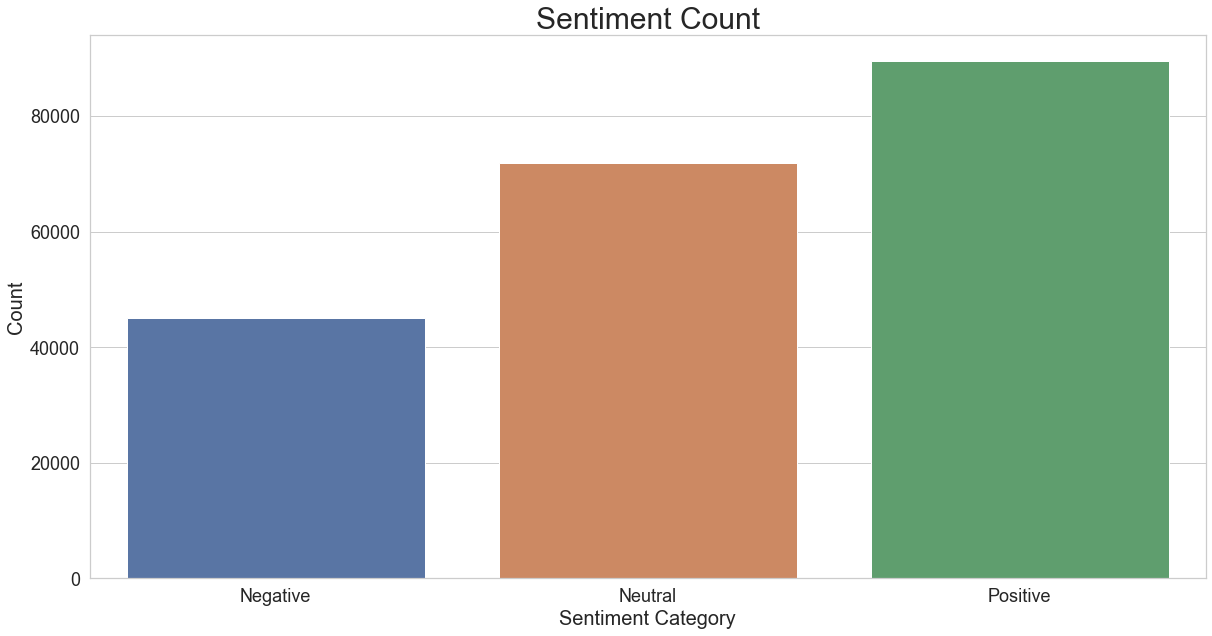

In [4]:
plt.figure(figsize=(20,10))
# set theme
sns.set_theme(style="whitegrid")
#countplot ploarity
sns.countplot(x=df.category)

plt.xlabel('Sentiment Category', fontsize=20)
plt.ylabel('Count', fontsize = 20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('Sentiment Count', fontsize=30)

In [21]:
# assign new df
df2 = df
# filter text column using removeFunc - see function for more notes
df2['filter_text'] = df.text.apply(removeFunc)
df2.head()

,text,score,category,filter_text
0,when modi promised “minimum government maximum...,-1.0,Negative,modi promised “minimum government maximum gove...
1,talk all the nonsense and continue all the dra...,0.0,Neutral,talk nonsense continue drama vote modi
2,what did just say vote for modi welcome bjp t...,1.0,Positive,say vote modi welcome bjp told rahul main camp...
3,asking his supporters prefix chowkidar their n...,1.0,Positive,asking supporters prefix chowkidar names modi ...
4,answer who among these the most powerful world...,1.0,Positive,answer among powerful world leader today trump...


In [22]:
# check na again
df2.isna().sum()

text           0
score          0
category       0
filter_text    0
dtype: int64

In [23]:
# assing split text column
df2['split_text'] = df2.filter_text.apply(tweet_to_words)
df2.isna().sum()

text           0
score          0
category       0
filter_text    0
split_text     0
dtype: int64

In [25]:
# save to csv
df2.to_csv('data_model/df.csv')

#### Text Vectorization

In [28]:
# load csv
df2= pd.read_csv('data_model/df.csv',index_col=0)

,text,score,category,filter_text,split_text
0,when modi promised “minimum government maximum...,-1.0,Negative,modi promised “minimum government maximum gove...,"['modi', 'promis', 'minimum', 'govern', 'maxim..."
1,talk all the nonsense and continue all the dra...,0.0,Neutral,talk nonsense continue drama vote modi,"['talk', 'nonsens', 'continu', 'drama', 'vote'..."
2,what did just say vote for modi welcome bjp t...,1.0,Positive,say vote modi welcome bjp told rahul main camp...,"['say', 'vote', 'modi', 'welcom', 'bjp', 'told..."
3,asking his supporters prefix chowkidar their n...,1.0,Positive,asking supporters prefix chowkidar names modi ...,"['ask', 'support', 'prefix', 'chowkidar', 'nam..."
4,answer who among these the most powerful world...,1.0,Positive,answer among powerful world leader today trump...,"['answer', 'among', 'power', 'world', 'leader'..."


In [24]:
df2.head()

,text,score,category,filter_text,split_text
0,when modi promised “minimum government maximum...,-1.0,Negative,modi promised “minimum government maximum gove...,"[modi, promis, minimum, govern, maximum, gover..."
1,talk all the nonsense and continue all the dra...,0.0,Neutral,talk nonsense continue drama vote modi,"[talk, nonsens, continu, drama, vote, modi]"
2,what did just say vote for modi welcome bjp t...,1.0,Positive,say vote modi welcome bjp told rahul main camp...,"[say, vote, modi, welcom, bjp, told, rahul, ma..."
3,asking his supporters prefix chowkidar their n...,1.0,Positive,asking supporters prefix chowkidar names modi ...,"[ask, support, prefix, chowkidar, name, modi, ..."
4,answer who among these the most powerful world...,1.0,Positive,answer among powerful world leader today trump...,"[answer, among, power, world, leader, today, t..."


In [26]:
df2['len'] = df2.split_text.apply(len)

df2.head()

,text,score,category,filter_text,split_text,len
0,when modi promised “minimum government maximum...,-1.0,Negative,modi promised “minimum government maximum gove...,"[modi, promis, minimum, govern, maximum, gover...",22
1,talk all the nonsense and continue all the dra...,0.0,Neutral,talk nonsense continue drama vote modi,"[talk, nonsens, continu, drama, vote, modi]",6
2,what did just say vote for modi welcome bjp t...,1.0,Positive,say vote modi welcome bjp told rahul main camp...,"[say, vote, modi, welcom, bjp, told, rahul, ma...",13
3,asking his supporters prefix chowkidar their n...,1.0,Positive,asking supporters prefix chowkidar names modi ...,"[ask, support, prefix, chowkidar, name, modi, ...",20
4,answer who among these the most powerful world...,1.0,Positive,answer among powerful world leader today trump...,"[answer, among, power, world, leader, today, t...",10


In [29]:
# choose x_data
x_data = df2.split_text

# make y_data dummies
y_data = pd.get_dummies(df2.category)

#obtain max x length
max_x_len = get_max_length(x_data)


# embed dimension
EMBED_DIM = 32
max_x_len

16

In [30]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # False becuase we already did it. 

# find formula to vectorize the text
token.fit_on_texts(x_data)

# converting text into vector
x_token = token.texts_to_sequences(x_data)

### this is the code to add the pad to x_train
x_token_pad = pad_sequences(x_token, maxlen=max_x_len, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # we need to add 1 because of 0 padding

In [31]:
# word counts of the tokenizer
token.word_counts

OrderedDict([('modi', 168391),
             ('promis', 4740),
             ('minimum', 638),
             ('govern', 9319),
             ('maximum', 284),
             ('expect', 2154),
             ('begin', 651),
             ('difficult', 505),
             ('job', 5229),
             ('reform', 517),
             ('state', 4804),
             ('take', 8312),
             ('year', 11682),
             ('get', 11836),
             ('justic', 549),
             ('not', 38231),
             ('busi', 2229),
             ('exit', 210),
             ('psu', 115),
             ('templ', 646),
             ('talk', 4521),
             ('nonsens', 486),
             ('continu', 1601),
             ('drama', 657),
             ('vote', 14589),
             ('say', 13879),
             ('welcom', 717),
             ('bjp', 20208),
             ('told', 1218),
             ('rahul', 7949),
             ('main', 1303),
             ('campaign', 3406),
             ('think', 8440),
             (

In [32]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(x_token_pad, y_data, test_size=0.25, random_state=42)

In [33]:
X_train.shape

(154945, 16)

In [34]:
y_train.shape

(154945, 3)

In [26]:
# saving to pickle file
with open('output/token_model1.pickle', 'wb') as handle:
    pickle.dump(token, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading from pickle file
with open('output/token_model1.pickle', 'rb') as handle:
    token = pickle.load(handle)

## Deep Learning

### Embedding with LSTM

In [35]:


#### add the model here:
lstm = Sequential()
# Embedding - common application is for text processing, changing integer into vectors
lstm.add(Embedding(total_words,EMBED_DIM,
                  input_length=max_x_len))
# lstm.add(Dropout(0.4))
lstm.add(LSTM(units=32, dropout=0.3, recurrent_dropout=0.3))
# lstm.add(Dropout(0.2))
# lstm.add(Dense(27, activation='sigmoid'))
# lstm.add(Dropout(0.2))
# lstm.add(Dense(9, activation='sigmoid'))
# lstm.add(Dropout(0.2))
lstm.add(Dense(3, activation='softmax'))

# show a graph of model
tf.keras.utils.plot_model(lstm, show_shapes=True)

### compile the model using: optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']
lstm.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
lstm.summary()
# Save model checkpoint and save best only
checkpoint = ModelCheckpoint('output/LSTM.h5', monitor='accuracy', save_best_only=True, verbose=1)
# fit and train model, call back based on checkpoint(best model)
history = lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 16, 32)            3611296   
                                                                 
 dropout_3 (Dropout)         (None, 16, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 3,619,715
Trainable params: 3,619,715
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
484

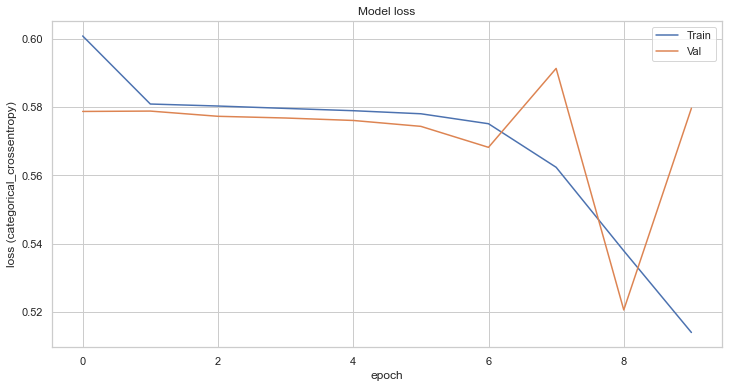

In [36]:
plt.figure(figsize=(12,6))
plt.plot(lstm.history.history['loss'][:])
plt.plot(lstm.history.history['val_loss'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (categorical_crossentropy)')
plt.legend(['Train', 'Val'], loc='upper right')

### Embedding, Conv1D with Bidirectional LSTM

In [37]:
#### add the model here:
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model = Sequential()
model.add(Embedding(total_words,EMBED_DIM, input_length=max_x_len))
# Conv1D is for regression, Conv2D is for images, Conv3D
model.add(Conv1D(filters=32, kernel_size=3, padding='same',activation='relu'))
# model.add(SpatialDropout1D(0.3))
model.add(MaxPooling1D(pool_size=2))
# since maxpooling returns 3dimension, we dont need reshape, if we connect to regular NN, we should flatten to change shape into 2D
# model.add(Flatten)
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
# model.add(Dense(16, activation='sigmoid'))
# model.add(Dropout(0.3))
# dense 3 output is based on y dimension, this y dimension is (_, 3)
model.add(Dense(3, activation='softmax'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='softmax'))

# show a graph of model
tf.keras.utils.plot_model(model, show_shapes=True)

### compile the model using: optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 16, 32)            3611296   
                                                                 
 conv1d (Conv1D)             (None, 16, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 32)            0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout_4 (Dropout)    

In [38]:
# tensor board log
log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Save model checkpoint and save best only
checkpoint = ModelCheckpoint('output/convBiLSTM.h5', monitor='accuracy', save_best_only=True, verbose=1)
# fit and train model, call back based on checkpoint(best model)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint,tensorboard_callback])

Epoch 1/10
2418/2422 [============================>.] - ETA: 0s - loss: 0.5818 - accuracy: 0.5266 - precision_4: 0.5472 - recall_4: 0.4572
Epoch 1: accuracy improved from -inf to 0.52651, saving model to output\convBiLSTM.h5
2422/2422 [==============================] - 25s 8ms/step - loss: 0.5818 - accuracy: 0.5265 - precision_4: 0.5472 - recall_4: 0.4572 - val_loss: 0.5749 - val_accuracy: 0.5360 - val_precision_4: 0.5510 - val_recall_4: 0.4734
Epoch 2/10
2422/2422 [==============================] - ETA: 0s - loss: 0.5762 - accuracy: 0.5335 - precision_4: 0.5519 - recall_4: 0.4769
Epoch 2: accuracy improved from 0.52651 to 0.53349, saving model to output\convBiLSTM.h5
2422/2422 [==============================] - 19s 8ms/step - loss: 0.5762 - accuracy: 0.5335 - precision_4: 0.5519 - recall_4: 0.4769 - val_loss: 0.5723 - val_accuracy: 0.5377 - val_precision_4: 0.5566 - val_recall_4: 0.4782
Epoch 3/10
2415/2422 [============================>.] - ETA: 0s - loss: 0.5733 - accuracy: 0.5367 -

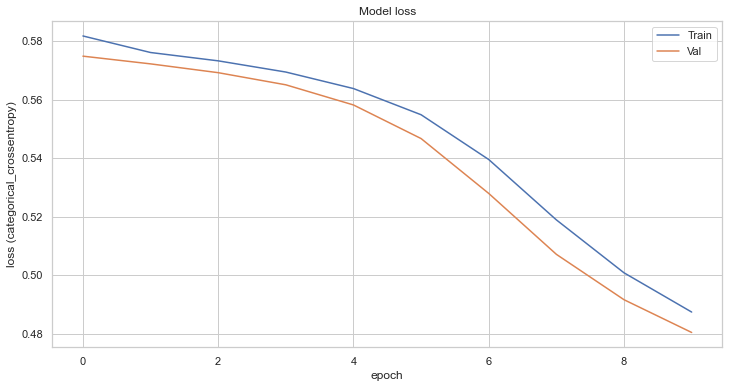

In [41]:
plt.figure(figsize=(12,6))
plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['val_loss'][:])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss (categorical_crossentropy)')
plt.legend(['Train', 'Val'], loc='upper right')

### GRU

In [14]:
gru = Sequential()
gru.add(Embedding(total_words,EMBED_DIM, input_length=max_x_len))
gru.add(GRU(32))
gru.add(Dropout(0.5))
# time took too long
# gru.add(Dense(9))
# gru.add(Dropout(0.25))
gru.add(Dense(3, activation='softmax'))

gru.compile(loss='binary_crossentropy', optimizer='SGD',metrics=['accuracy', Precision(), Recall()])   
    
gru.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [22]:
X_train.shape

(154687, 141)

In [40]:
inputs = Input(shape=(max_x_len))
x = Embedding(total_words,EMBED_DIM,
                  input_length=max_x_len)(inputs)
# x = GRU(32, recurrent_dropout=0.5, return_sequences=True)(x)
x = GRU(32, recurrent_dropout=0.5)(x)
x = Dropout(0.5)(x)
outputs = Dense(3,activation = 'softmax')(x)
model = Model(inputs, outputs)
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy', Precision(), Recall()])   
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 141)]             0         
                                                                 
 embedding_12 (Embedding)    (None, 141, 32)           3611296   
                                                                 
 gru_18 (GRU)                (None, 32)                6336      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 3)                 99        
                                                                 
Total params: 3,617,731
Trainable params: 3,617,731
Non-trainable params: 0
_________________________________________________________________


In [41]:
# tensor board log
# log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Save model checkpoint and save best only
checkpoint = ModelCheckpoint('output/gru.h5', monitor='accuracy', save_best_only=True, verbose=1)
# fit and train model, call back based on checkpoint(best model)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint], verbose=1)

Epoch 1/10
2417/2417 [==============================] - ETA: 0s - loss: 0.6217 - accuracy: 0.4313 - precision_11: 0.4333 - recall_11: 0.1282
Epoch 1: accuracy improved from -inf to 0.43126, saving model to output\gru.h5
2417/2417 [==============================] - 284s 113ms/step - loss: 0.6217 - accuracy: 0.4313 - precision_11: 0.4333 - recall_11: 0.1282 - val_loss: 0.6187 - val_accuracy: 0.4357 - val_precision_11: 0.9091 - val_recall_11: 1.9394e-04
Epoch 2/10
2417/2417 [==============================] - ETA: 0s - loss: 0.6193 - accuracy: 0.4339 - precision_11: 0.4389 - recall_11: 0.0965
Epoch 2: accuracy improved from 0.43126 to 0.43388, saving model to output\gru.h5
2417/2417 [==============================] - 305s 126ms/step - loss: 0.6193 - accuracy: 0.4339 - precision_11: 0.4389 - recall_11: 0.0965 - val_loss: 0.6185 - val_accuracy: 0.4357 - val_precision_11: 0.8235 - val_recall_11: 0.0019
Epoch 3/10
2417/2417 [==============================] - ETA: 0s - loss: 0.6187 - accuracy: 

KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs/fit

### LDA

In [156]:
df2.head()
df2['clean_text'] = df2.split_text.apply(lambda x: ' '.join(x))
df2.head()
df2.to_csv('data_model/clean_df.csv')
df2.shape
df = pd.read_csv('data_model/clean_df.csv')
cleandf = df.dropna(axis=0)
cleandf.shape
cleandf = cleandf.iloc[:,2:]
cleandf.to_csv('data_model/clean_df.csv')
cleandf.info()

(206594, 7)

In [161]:
df = pd.read_csv('data_model/clean_df.csv',index_col=0)
df.isna().sum()

Unnamed: 0     0
text           0
score          0
category       0
filter_text    0
split_text     0
clean_text     0
dtype: int64

In [170]:
# ignore high freq and low freq
cv = CountVectorizer(max_df=0.95, min_df=2)

# document term matrix - dtm
dtm = cv.fit_transform(df['clean_text'])


In [175]:
# initialize insteace with 4 category, since there was 4 different data sets to each category.
LDA = LatentDirichletAllocation(n_components=4,random_state=42)
LDA.fit(dtm)

LatentDirichletAllocation(n_components=4, random_state=42)

In [176]:
# print top 15 words in each topic
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    #print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['give', 'rahul', 'time', 'work', 'like', 'bjp', 'good', 'one', 'govt', 'year', 'peopl', 'congress', 'india', 'not', 'modi']


THE TOP 15 WORDS FOR TOPIC #1
['see', 'parti', 'leader', '2019', 'say', 'chowkidar', 'narendra', 'india', 'not', 'like', 'peopl', 'elect', 'vote', 'bjp', 'modi']


THE TOP 15 WORDS FOR TOPIC #2
['announc', 'drdo', 'satellit', 'minist', 'indian', 'scientist', 'say', 'nation', 'space', 'credit', 'not', 'narendra', 'pakistan', 'india', 'modi']


THE TOP 15 WORDS FOR TOPIC #3
['compani', 'team', 'also', 'would', 'india', 'nirav', 'get', 'one', 'hindu', 'use', 'not', 'muslim', 'like', 'modi', 'hai']




In [177]:
# topic results
topic_results = LDA.transform(dtm)

# append to the df
df['lda_topic']=topic_results.argmax(axis=1)
df.head()

,Unnamed: 0,text,score,category,filter_text,split_text,clean_text,lda_topic
0,0,when modi promised “minimum government maximum...,-1.0,Negative,modi promised “minimum government maximum gove...,"['modi', 'promis', 'minimum', 'govern', 'maxim...",modi promis minimum govern maximum govern expe...,0
1,1,talk all the nonsense and continue all the dra...,0.0,Neutral,talk nonsense continue drama vote modi,"['talk', 'nonsens', 'continu', 'drama', 'vote'...",talk nonsens continu drama vote modi,1
2,2,what did just say vote for modi welcome bjp t...,1.0,Positive,say vote modi welcome bjp told rahul main camp...,"['say', 'vote', 'modi', 'welcom', 'bjp', 'told...",say vote modi welcom bjp told rahul main campa...,1
3,3,asking his supporters prefix chowkidar their n...,1.0,Positive,asking supporters prefix chowkidar names modi ...,"['ask', 'support', 'prefix', 'chowkidar', 'nam...",ask support prefix chowkidar name modi great s...,1
4,4,answer who among these the most powerful world...,1.0,Positive,answer among powerful world leader today trump...,"['answer', 'among', 'power', 'world', 'leader'...",answer among power world leader today trump pu...,1


In [178]:
topic_results[0].round(2)
topic_results[0].argmax()

# append to the df
df['lda_topic']=topic_results.argmax(axis=1)
df.head()

,Unnamed: 0,text,score,category,filter_text,split_text,clean_text,lda_topic
0,0,when modi promised “minimum government maximum...,-1.0,Negative,modi promised “minimum government maximum gove...,"['modi', 'promis', 'minimum', 'govern', 'maxim...",modi promis minimum govern maximum govern expe...,0
1,1,talk all the nonsense and continue all the dra...,0.0,Neutral,talk nonsense continue drama vote modi,"['talk', 'nonsens', 'continu', 'drama', 'vote'...",talk nonsens continu drama vote modi,1
2,2,what did just say vote for modi welcome bjp t...,1.0,Positive,say vote modi welcome bjp told rahul main camp...,"['say', 'vote', 'modi', 'welcom', 'bjp', 'told...",say vote modi welcom bjp told rahul main campa...,1
3,3,asking his supporters prefix chowkidar their n...,1.0,Positive,asking supporters prefix chowkidar names modi ...,"['ask', 'support', 'prefix', 'chowkidar', 'nam...",ask support prefix chowkidar name modi great s...,1
4,4,answer who among these the most powerful world...,1.0,Positive,answer among powerful world leader today trump...,"['answer', 'among', 'power', 'world', 'leader'...",answer among power world leader today trump pu...,1


## Reference

Data from: 
https://www.kaggle.com/code/kritanjalijain/twitter-sentiment-analysis-lstm/notebook

GRU from:
https://www.kaggle.com/code/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert#GRU's